In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [2]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_juli.csv", sep=",")

In [3]:
df.dropna(inplace=True)

In [4]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [5]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [6]:
candidate_lags = range(1, 18) 
#candidate_lags= [2,3,4]

In [7]:
cutoffs = pd.date_range(
    start="2020-09-30",   # first end-of-month
    end="2021-08-31",     # last end-of-month
    freq="ME"              # month-end
).to_list()

In [8]:
cutoffs

[Timestamp('2020-09-30 00:00:00'),
 Timestamp('2020-10-31 00:00:00'),
 Timestamp('2020-11-30 00:00:00'),
 Timestamp('2020-12-31 00:00:00'),
 Timestamp('2021-01-31 00:00:00'),
 Timestamp('2021-02-28 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-04-30 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-30 00:00:00'),
 Timestamp('2021-07-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00')]

In [9]:
###resultat valg 2021
valg = {
    "Ap": [26.3],
    "Høyre": [20.4],
    "Frp": [11.6],
    "SV": [7.6],
    "Sp": [13.5],
    "KrF": [3.8],
    "Venstre": [4.6],
    "MDG": [3.9],
    "Rødt": [4.7],
    "Andre": [3.6],
}

###resultat valg 2017
#valg = {
#    "Ap": [27.4],
#    "Høyre": [25.0],
#    "Frp": [15.2],
#    "SV": [6.0],
#    "Sp": [10.3],
#    "KrF": [4.2],
#    "Venstre": [4.4],
#    "MDG": [3.2],
#    "Rødt": [2.4],
#    "Andre": [1.8],
#}



# Lage DataFrame
valg_df = pd.DataFrame(valg)
results = []
finals = []

In [10]:
def create_lags_and_trends(df, parties, lags=[3,6]):
    """
    Create lag and trend columns for each party.
    
    Args:
        df: DataFrame with party columns
        parties: list of party names
        lags: list of integers representing lag in months
    
    Returns:
        DataFrame with lag and trend columns added
    """
    df_new = df.copy()
    
    for party in parties:
        for lag in lags:
            lag_col = f"{party}_lag{lag}"
            trend_col = f"{party}_trend{lag}"
            
            df_new[lag_col] = df_new[party].shift(lag)
            df_new[trend_col] = (df_new[party] - df_new[party].shift(lag))/lag
    
    return df_new

In [11]:
lags = [1,2,3,4,5,6]
parties= ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']
#df = create_lags_and_trends(df, parties, lags=lags)
#df.dropna(inplace=True)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_24440\837430345.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[lag_col] = df_new[party].shift(lag)
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_24440\837430345.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new[trend_col] = (df_new[party] - df_new[party].shift(lag))/lag
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_24440\837430345.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

In [12]:
y_true = valg_df.values.reshape(1, -1)[0]

In [13]:
for i, cutoff in enumerate(cutoffs):
    for lag in candidate_lags:
            # Fit model on training set
            df_en=df[parties]


            df_ex = df[[c for c in df.columns if c not in df_en.columns]].iloc[1:]
        
            #df_ex=df[[
            #'Ap_skandale_lag6', 
            #'Hoyre_skandale_lag6', 
            #'Frp_skandale_lag6',
            #'Ap_reg_lag6',
            #'Hoyre_reg_lag6',   
            #'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
            #'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

            steps = len(cutoffs) - i +1

            ex_future=df_ex.loc[df_ex.index >= cutoff][:steps]
        
            df_en=df_en.loc[df_en.index <= cutoff]
            df_ex=df_ex.loc[df_ex.index <= cutoff]
            
            df_orig=df_en
            df_en_val = df_en.diff().dropna() 
            
            #print(ex_future)
            #print(cutoff)
            #model = VAR(df_en_val)
            model = VAR(endog=df_en_val, exog=df_ex)
            model_fitted = model.fit(maxlags=lag, trend='n', method = 'ols')
            
            #model = VARMAX(endog=df_en_val, exog=df_ex, order=(1,0), trend='n')
            #model_fitted = model.fit(disp=True, method='powell', cov_type='robust_approx', maxiter=100)
            #print(model_fitted.summary())
            
            #print(f"lag={lag}, steps={steps} and cutoff={cutoff}")
            forecast_dates = pd.date_range(start=cutoff, periods=steps, freq='ME')
            #print(forecast_dates)
            forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps,  exog_future=ex_future)
            
            #forecast_res = model_fitted.get_forecast(steps=steps, exog=ex_future)
            #forecast = forecast_res.predicted_mean
            
            #print(forecast)
            
            last_actual_value = df_orig.iloc[-1]  # Last known actual data point
            #print(last_actual_value)
            forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en_val.columns)
    
            forecast_df = forecast_df.cumsum() + last_actual_value
            date_to_extract = "2021-09-30"
            estimate_row = forecast_df.loc[date_to_extract]
            finals.append(estimate_row)
            #print(estimate_row.values)

            y_pred = estimate_row.values.reshape(1, -1)[0]  
            # Compute error metric (MSE here)
            mse = median_absolute_error(y_true, y_pred)
            mse_pp = median_absolute_error(y_true, last_actual_value.values.reshape(1, -1)[0])
    
            results.append((cutoff,lag,steps, mse, mse_pp))


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

In [14]:
last_actual_value.values.reshape(1, -1)[0]

array([24. , 20.1, 10.3,  8.8, 14.1,  3.6,  4.1,  5.5,  5.2,  4.4])

In [15]:
y_true

array([26.3, 20.4, 11.6,  7.6, 13.5,  3.8,  4.6,  3.9,  4.7,  3.6])

In [16]:
finals

[Ap         23.122257
 Hoyre      18.737043
 Frp        12.751829
 SV          9.613567
 SP         13.086433
 KrF         3.900000
 Venstre     4.925914
 MDG         4.549390
 Rodt        5.138262
 Andre       4.150610
 Name: 2021-09-30 00:00:00, dtype: float64,
 Ap         23.153788
 Hoyre      18.766031
 Frp        12.699581
 SV          9.607759
 SP         13.069758
 KrF         3.907495
 Venstre     4.922274
 MDG         4.556189
 Rodt        5.148032
 Andre       4.143811
 Name: 2021-09-30 00:00:00, dtype: float64,
 Ap         23.153582
 Hoyre      18.766850
 Frp        12.700645
 SV          9.607780
 SP         13.070366
 KrF         3.906813
 Venstre     4.922884
 MDG         4.555137
 Rodt        5.146400
 Andre       4.144235
 Name: 2021-09-30 00:00:00, dtype: float64,
 Ap         23.142940
 Hoyre      18.761571
 Frp        12.715741
 SV          9.612480
 SP         13.073692
 KrF         3.906560
 Venstre     4.924120
 MDG         4.550052
 Rodt        5.141556
 Andre    

In [17]:
results_df=pd.DataFrame(results, columns=["cutoff", "lag", "steps", "MSE", "mse_pp"])

In [18]:
results_df

,cutoff,lag,steps,MSE,mse_pp
0,2020-09-30,1,13,0.600000,0.9
1,2020-09-30,2,13,0.600000,0.9
2,2020-09-30,3,13,0.599686,0.9
3,2020-09-30,4,13,0.597709,0.9
4,2020-09-30,5,13,0.599670,0.9
...,...,...,...,...,...
199,2021-08-31,13,2,0.912768,0.7
200,2021-08-31,14,2,0.747000,0.7
201,2021-08-31,15,2,0.778706,0.7
202,2021-08-31,16,2,0.730243,0.7


In [19]:
best_lags = results_df.loc[results_df.groupby("cutoff")["MSE"].idxmin()]

In [20]:
best_lags

,cutoff,lag,steps,MSE,mse_pp
3,2020-09-30,4,13,0.597709,0.90
23,2020-10-31,7,12,0.800540,1.10
42,2020-11-30,9,11,0.803165,0.90
66,2020-12-31,16,10,0.788192,0.95
84,2021-01-31,17,9,1.122366,0.85
96,2021-02-28,12,8,0.377066,1.05
118,2021-03-31,17,7,0.378303,1.10
134,2021-04-30,16,6,0.544202,1.30
151,2021-05-31,16,5,0.596587,0.95
161,2021-06-30,9,4,0.636174,0.90


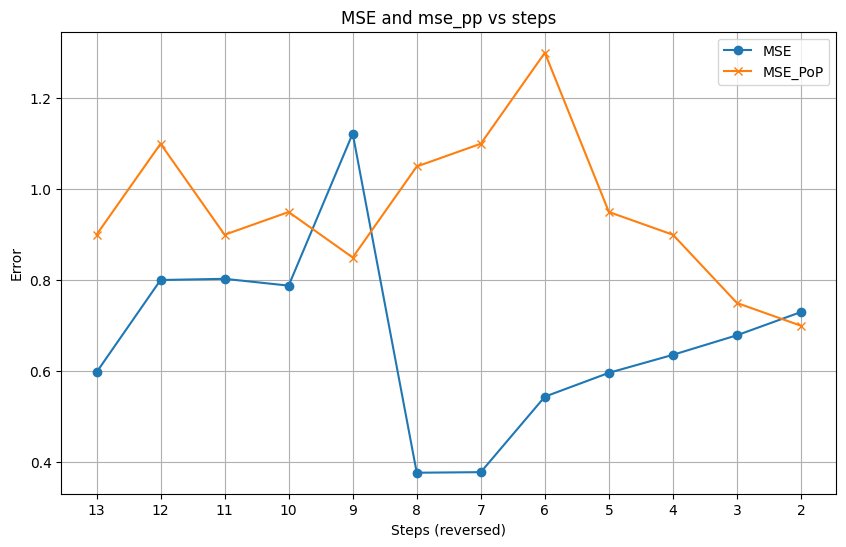

In [21]:
df_sorted = best_lags.sort_values("steps", ascending=True)  # reverse lag order for x-axis

plt.figure(figsize=(10, 6))
plt.plot(df_sorted["steps"], df_sorted["MSE"], marker='o', label="MSE")
plt.plot(df_sorted["steps"], df_sorted["mse_pp"], marker='x', label="MSE_PoP")

plt.xlabel("Steps (reversed)")
plt.ylabel("Error")
plt.title("MSE and mse_pp vs steps")
plt.xticks(df_sorted["steps"])  # show all lag values on x-axis
plt.gca().invert_xaxis()      # reverse x-axis so largest lag is left
plt.legend()
plt.grid(True)
plt.show()

In [22]:
filtered = results_df[results_df["lag"] == np.maximum(10-results_df["steps"]*2, 1)]

##filtered = results_df[results_df["lag"] == np.maximum(3,np.minimum(7,results_df["steps"]-4))]
filtered = results_df[results_df["lag"] == 6]

In [23]:
filtered


,cutoff,lag,steps,MSE,mse_pp
5,2020-09-30,6,13,0.599670,0.90
22,2020-10-31,6,12,0.800540,1.10
39,2020-11-30,6,11,0.824878,0.90
56,2020-12-31,6,10,1.072606,0.95
73,2021-01-31,6,9,1.135829,0.85
90,2021-02-28,6,8,0.778815,1.05
107,2021-03-31,6,7,0.528520,1.10
124,2021-04-30,6,6,0.780061,1.30
141,2021-05-31,6,5,1.012481,0.95
158,2021-06-30,6,4,0.648560,0.90


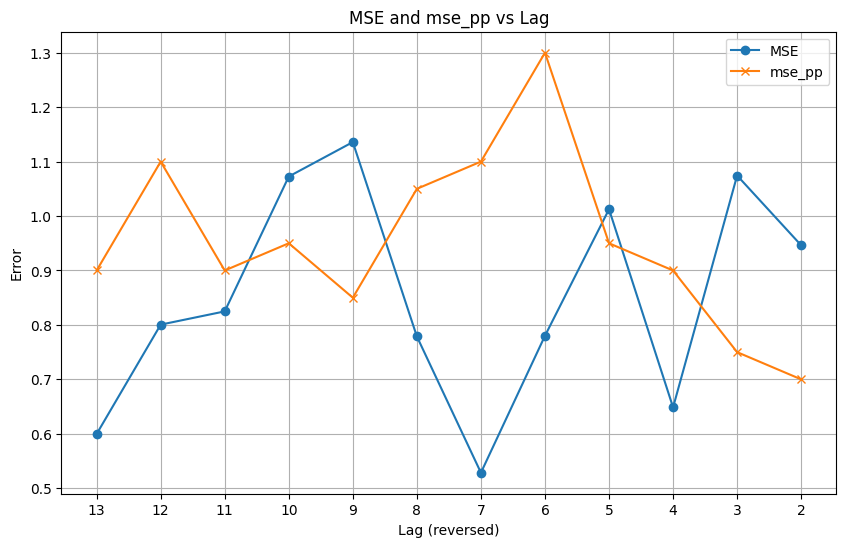

In [24]:
df_sorted = filtered.sort_values("steps", ascending=False)  # reverse lag order for x-axis

plt.figure(figsize=(10, 6))
plt.plot(df_sorted["steps"], df_sorted["MSE"], marker='o', label="MSE")
plt.plot(df_sorted["steps"], df_sorted["mse_pp"], marker='x', label="mse_pp")

plt.xlabel("Lag (reversed)")
plt.ylabel("Error")
plt.title("MSE and mse_pp vs Lag")
plt.xticks(df_sorted["steps"])  # show all lag values on x-axis
plt.gca().invert_xaxis()      # reverse x-axis so largest lag is left
plt.legend()
plt.grid(True)
plt.show()